# Deep Convolutional Generative Adversarial Network (DCGAN) for Generetaing Senthetic Wafer Bin Maps Based on WM-811k dataset

This code will show the steps on generating synthestic WBM images using DCGAN in order to balance the WM-811k dataset and increase the data for each class. 

General notes about the code before we start:

- This is modified version from the Tensorflow tutorial ([Reference](https://www.tensorflow.org/tutorials/generative/dcgan))

- This code is part of the codes implemented in the following paper: [An Improved Capsule Network (WaferCaps) for Wafer Bin Map Classification Based on DCGAN Data Upsampling](https://ieeexplore.ieee.org/document/9646243). Please feel free to cite our paper if you found the code useful for your research :)




## Brief Introduction to GAN

GAN was first introduced in 2014 by [Goodfellow et al.](https://dl.acm.org/doi/10.5555/2969033.2969125). It consists of two neural networks, namely, generator and discriminator as shown in the figure below. 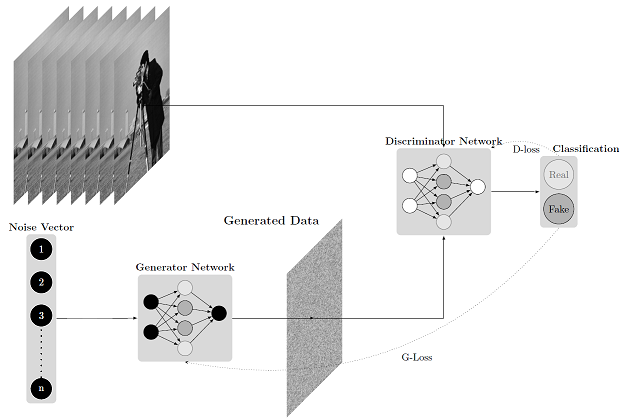
The original paper suggested that both generator and discriminator are multilayer perceptron networks (MLP). The generator is responsible for producing synthetic images that look like the training dataset and supply these produced images for the discriminator. The discriminator is responsible for making the decision whether the produced images from the generator look similar to the real data or not using binary classification scheme. This framework can be used to generate realistic new images that are almost identical to pre-existing training dataset by training the generator and discriminator simultaneously using adversarial process.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at distinguishing real from synthetic images. The process reaches equilibrium when the discriminator can no longer distinguish between real and synthetic images. The minimax concept suggested by [Goodfellow et al.](https://dl.acm.org/doi/10.5555/2969033.2969125) to fulfill this objective, which is given by the equation:

\begin{equation}
\min_{G}\max_{D}V(D,G)=\mathbb{E}_{x\sim p_{data}(x)}\left[\log\left(D(x)\right)\right] +\mathbb{E}_{z\sim p_{z}(z)}\left[\log\left(1-D\left(G(z)\right)\right)\right]
\label{eq:minmax}
\end{equation}
where $D(x)$ is the probability that $x$ belong to the original data distribution, $G(z)$ is the generator function that maps to the data space, $\mathbb{E}_{x\sim p_{data}(x)}$ is the expected value over all real samples, $\mathbb{E}_{z\sim p_{z}(z)}$ is the expected value over all fake samples.

The equation above indicates that the discriminator is trained to maximize the probability $\log\left(D(x)\right)$ of assigning the correct label  to both the generated synthetic data probability and real training data using  while the generator is trained to minimize $\log\left(1-D\left(G(z)\right)\right)$. 

Since discriminator is performing binary classification (real or fake), binary cross entropy (BCE) loss function (given by equation below) is used for the discriminator to penalize itself for misclassifying real and fake images.

\begin{equation}
    J_{q}(w)=-\frac{1}{N}\sum_{n=1}^{N}y_{n}\cdot\log\left(q(y_{n})\right)+\left(1-y_{n}\right)\cdot\log\left(1-q(y_{n}))\right)
\end{equation}
where $y_{n}$ is the label  for training example $n$ (1 for real samples and 0 for fake), $q(y)$ is the predicted probability of the point being real for all $N$ points.

## Brief Introduction to DCGAN

DCGAN was introduced in 2016 by [Radford et al.](https://arxiv.org/abs/1511.06434)  and is considered an extension of the original GAN proposed by [Goodfellow et al.](https://dl.acm.org/doi/10.5555/2969033.2969125). The architecture of DCGAN is almost the same in the original GAN except that convolutional and convolutional transpose (deconvolutional) layers are used in discriminator and generator networks respectively instead of the MLP structure. In DCGAN, the generator network receives a one-dimensional random Gaussian vector as an input. Multiple deconvolutional layers are then applied to upscale the vector into random noise image.

## Our DCGAN for WM-811k Data

In this code we will create the DCGAN shown figure below, which is intended to generate $64 \times 64$ pixels images of a specific WM-811k data class. In this tutorial we will use the Donut class as an example. 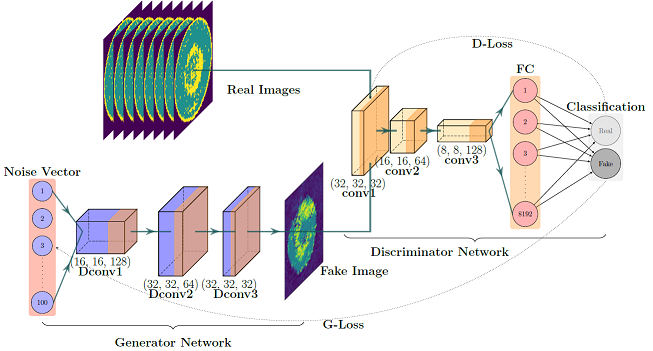

In our DCGAN, the generator network receives a one-dimensional random Gaussian vector of size  $[100,]$ as an input. Multiple deconv layers are then applied to upscale the vector into $64 \times 64$ random noise image. All the deconv layers are followed by ReLU activation function and batch normalization was used in these layers in order to stabilize the learning process. The final layer will have the same size as the target image ($64 \times 64$), which will be a noise image in the first epoch of training that will evolve in each epoch to produce the wanted synthetic image.

##### Enough talking and lets do some coding :) 
First we will import the packages we want to use in the code as shown below

In [49]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display 
import cv2

In the below cell we access the images from the folder where they are stored in, convert them into grayscale and normalize them.

Sample images:


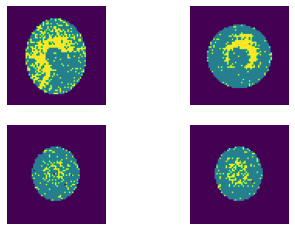

In [50]:
# In the below code write the path of the folder that you saved the images in as shown below
path = r'Donut/*.png'

# In the below code we loop into each image in the folder and convert into grayscale. All the images are then saved in one
# array (training data)
X_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(path)])

# Here we print some samples to see what kind of images we are dealing with
print('Sample images:')
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(X_train[i], cmap='viridis')
    plt.axis('off')

# In the below code we make sure that shape of the image array has the dimension 64,64,1 and in float32 format
# so that can we can feed it to 
train_images = X_train.reshape(X_train.shape[0], 64, 64, 1).astype('float32')

# Here we normalize the images
train_images = (train_images / 255 - 0.5) * 2
train_images = np.clip(train_images, -1, 1)

In the below cell we define batch size and shuffle the training data.

In [51]:
BATCH_SIZE = 8

# This is an optinal step and it is recommended when you have big data size and high variance in your data.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

### Generator Network

In the next cell we define the genreator network function illustrated by the figure and table below.

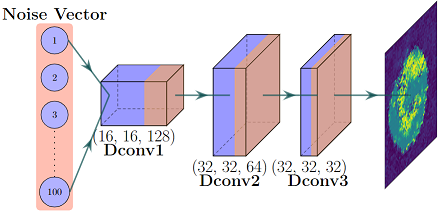


|Layer| Type        | Input Size              | Kernel Size / Stride | Actication   | Batch Normalization? | Output Size |
|----:|:------------|:------------------------|:---------------------|:-------------|:---------------------|:------------|
| 1   | FC          | $[100,]$                | 3/1                  | -            |      No              |$[16, 16, 128]$|
| 2   | Deconv      | $[16,16,128]$           | 3/2                  | ReLU         |      Yes             |$[32,32,64]$ |
| 3   | Deconv      | $[32,32,64]$            | 3/1                  | ReLU         |      Yes             |$[32,32,32]$ |
| 4   | Deconv      | $[32,32,32]$            | 3/2                  | tanh         |      No              |$[64,64,1]$  |

In [52]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # 1st layer: We start by feeding the generator network with a noise vector of size [100,] and upsample it
    # using deconv operation into size of [16, 16, 128]
    model.add(layers.Dense(16*16*128, input_shape=(100,)))
    model.add(layers.Reshape((16, 16, 128)))
    # This line of code to ensure that the size of the feature map is [16, 16, 128]
    assert model.output_shape == (None, 16, 16, 128) 
    
    # 2nd layer: the previous layer is fed into another layer that has 64 filters, kernel size of 3 and stride of 2.  
    # The resulting feature map is of size [32, 32, 64]
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    # This line of code to ensure that the size of the feature map is [32, 32, 64]
    assert model.output_shape == (None, 32, 32, 64)
    # Batch normalization is common practice in generator networks to stabilize the training process
    model.add(layers.BatchNormalization(momentum=0.8))
    # ReLU activation function is used in this layer with alpha = 0.2
    model.add(layers.ReLU(0.2))
    
    # 3rd layer: the previous layer is fed into another layer that has 32 filters, kernel size of 3 and stride of 1.  
    # The resulting feature map is of size [32, 32, 32]
    model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
    # This line of code to ensure that the size of the feature map is [16, 16, 128]
    assert model.output_shape == (None, 32, 32, 32)
    # Batch normalization is common practice in generator networks to stabilize the training process
    model.add(layers.BatchNormalization(momentum=0.8))
    # ReLU activation function is used in this layer with alpha = 0.2
    model.add(layers.ReLU(0.2))
    
    #################################
    # Optional layer: you can consider using additional layers for different images but currently for the donut WM811K images
    # we do not need that
    #model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
    #assert model.output_shape == (None, 32, 32, 64)
    #model.add(layers.BatchNormalization(momentum=0.8))
    #model.add(layers.ReLU(0.2))
    ################################################
    
    # final layer: the previous layer is fed into the final layer that has one filter (final image), 
    # kernel size of 3 and stride of 2. The resulting feature map has the same size as final image [64, 64, 1]
    # tanh actication was also used in the final layer
    model.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))
    # This line of code to ensure that the size of the feature map is [64, 64, 1]
    assert model.output_shape == (None, 64, 64, 1)

    return model

The code below shows how the noise victor is trnasformed into a noise image of $64 \times 64$ via the deconv layers of the generator. Hence: we did not strart training yet!

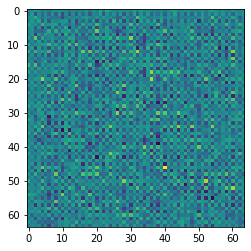

In [53]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='viridis')

### Discriminator Network

In the cell below we define the discriminator network function illustrated by the figure and table below.

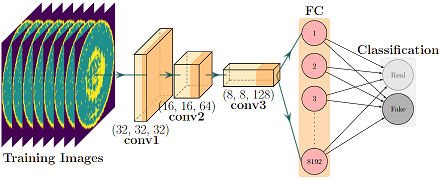

|Layer| Type        | Input Size              | Kernel Size / Stride | Actication   | Batch Norm./ Dropout?| Output Size |
|----:|:------------|:------------------------|:---------------------|:-------------|:---------------------|:------------|
| 1   | Conv        | $[64, 64, 1]$           | 3/2                  | L.ReLU       |      Dropout         |$[32,32,32]$ |
| 2   | Conv        | $[32,32,32]$            | 3/2                  | L.ReLU       |      Batch Norm.     |$[16,16,64]$ |
| 3   | Conv        | $[16,16,64]$            | 3/2                  | L.ReLU       |      Batch Norm.     |$[8,8,128]$  |
| 4   | FC          | $[8,8,128]$             | -                    | -            |      -               |$[8192,]$    |
| 5   | FC          | $[8192,]$               | -                    | Sigmoid      |      -               |$[1,]$       |

In [54]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # 1st layer: We start by feeding the discriminator network with training images of donut class that has  
    # image size of [64, 64, 1]. The image is converted into feature map of size [32, 32, 32] using 32 filters, 
    # kernel size of 3 and stride of 2.
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same',
                         input_shape=(64, 64, 1), kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    # LeakyReLU activation function is used in this layer
    model.add(layers.LeakyReLU(0.2))
    # Dropout was used to reduce overfitting and for better learning performance
    model.add(layers.Dropout(0.3))

    # 2nd layer: the previous layer is fed into another layer that has 64 filters, kernel size of 3 and stride of 2.  
    # The resulting feature map is of size [16, 16, 64]
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    # Batch normalization is common practice in generator networks to stabilize the training process
    model.add(layers.BatchNormalization(momentum=0.8))
    # LeakyReLU activation function is used in this layer
    model.add(layers.LeakyReLU(0.2))
    
    #### This is an additional layer
    #model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    #model.add(layers.BatchNormalization(momentum=0.8))
    #model.add(layers.LeakyReLU(0.2))
    ###################################
    
    # 3rd layer: the previous layer is fed into another layer that has 128 filters, kernel size of 3 and stride of 2.  
    # The resulting feature map is of size [8, 8, 128]
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    # Batch normalization is common practice in generator networks to stabilize the training process
    model.add(layers.BatchNormalization(momentum=0.8))
    # LeakyReLU activation function is used in this layer
    model.add(layers.LeakyReLU(0.2))
    
    # 4th layer: the previous layer is flattend into FC layer as preparation for classification procedure. The resulting layer
    # has size of [8192,]
    model.add(layers.Flatten())
    
    # Final layer: this is the final layer for classification, note that we used Sigmoid activation function
    # as our disrminator is binary classifier i.e. real/fake. The final output has a size of [1,]
    # which corresponds to the classification result
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

The code below shows the expected output of the discriminator network using the Sigmoid activation function.

In [55]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5000177]], shape=(1, 1), dtype=float32)


We then define the loss function (binary cross entropy) for our network, which is given by the following equation 

\begin{equation}
    J_{q}(w)=-\frac{1}{N}\sum_{n=1}^{N}y_{n}\cdot\log\left(q(y_{n})\right)+\left(1-y_{n}\right)\cdot\log\left(1-q(y_{n}))\right)
\end{equation}

In [56]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

This function measures the discriminator's ability to distinguish real images from fakes by comparing the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [57]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

The generator's loss measures how well it was able to trick the discriminator. If the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [58]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

We then define the optimizers and learning rate of our generator and discriminator networks as both of them will train separately.

In [59]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

For not losing epochs performance, we can define check points to save the models at different stages.

In [60]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Before we start with the training process, we define the epochs number for our model, the dimension of the noise vector. We also define a variable called seed that we could use after the training takes place to feed the generator with the random noise vector and generate a synthetic samples (e.g. four samples).

In [61]:
# I chose 100 epochs for quicker execution of the code but feel free to alter this.

EPOCHS = 100
noise_dim = 100


num_examples_to_generate = 4
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [62]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

The function below intiates the training process, show the time for each epoch and save the model on each 15 epochs. The result of each epoch will also be displayed.

In [63]:
def train(dataset, epochs):
      for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

This function is used to generate and save images.

In [64]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(2,2))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='viridis')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

We call the function for training here to intilize the training process ...

Note that at the begining the generator will not perform well and will show images that look like random noise, but by more epochs pass the model will start generate images that look similar to the real ones.

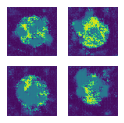

In [65]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [66]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Next 3 cells are used to visulaize the resulted images from the generator in GIF sequence.

In [67]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

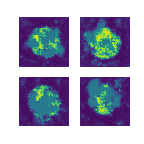

In [68]:
display_image(EPOCHS)

In [69]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


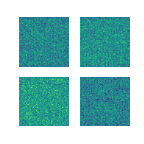

In [70]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

You can also save the final epoch of the model as shown below and load the saved model in a later python file. Note that you should supply the generator with the seed variable that contains the dimension of the noise vector [100,0] and the number of examples you want to generate.

In [71]:
# Write the path you want to save your last epoch in
generator.save('GAN_model_100epochs_donut_batch_size_8')

INFO:tensorflow:Assets written to: GAN_model_100epochs_donut_batch_size_8/assets


#### The below code can be run on a different Python file

In [72]:
model = tf.keras.models.load_model('GAN_model_100epochs_donut_batch_size_8')


In [73]:
seed = tf.random.normal([4, noise_dim])

In [74]:
seed.shape

TensorShape([4, 100])

In [75]:
predictions = model(seed)

In [76]:
predictions.shape

TensorShape([4, 64, 64, 1])

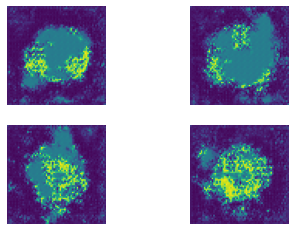

In [77]:
# Print samples of generated images
for i in range(predictions.shape[0]):
    plt.subplot(2, 2, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='viridis')
    plt.axis('off')

#### Idea
You can perform post-processing step to choose the best pictures of DCGAN by applying relvant template matching techniques (e.g. NCC) to compare the generated images from the generator with the real ones using certain threshold. Furthemore, since these images have only three intensity levels, you can round up/down the pixel generated to its nearest value intensity.

Thank you for attending this tutorial, I hope it was useful. Do not forget to have a look at our paper for more details here:

[An Improved Capsule Network (WaferCaps) for Wafer Bin Map Classification Based on DCGAN Data Upsampling](https://ieeexplore.ieee.org/document/9646243)